<a href="https://colab.research.google.com/github/bbleach/CNN-Face-Alignment/blob/main/CV_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This colab worksheet provides a starting point for the computer vision assignment. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [4]:
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it 
# rather than repeatedly downloading it.

#!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
!wget "https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz" -O training_images.npz

# The test images (without points)
#!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
!wget "https://sussex.box.com/shared/static/xxlgvjpa86s6xgjzy5im06saoj57s7gt.npz" -O test_images.npz

# The example images are here
#!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz
!wget "https://sussex.box.com/shared/static/kbodelmaqw5dd59i5x2kis55lor7ydhf.npz" -O examples.npz



--2022-04-19 13:37:42--  https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.box.com (sussex.box.com)... 185.235.236.197
Connecting to sussex.box.com (sussex.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2022-04-19 13:37:43--  https://sussex.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2022-04-19 13:37:43--  https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.app.box.com (sussex.app.box.com)... 185.235.236.201
Connecting to sussex.app.box.com (sussex.app.box.com)|185.235.236.201|:443... connected.
HTTP request sent, awaiting response... 302 Found


# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [5]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', 'f313a54fc57a1235e6307d176fc5fc83fd7ec530')
confirm_checksum('test_images.npz', '4b9efd8eb3b87c07d9c5400ef2494d476bc318a3')
confirm_checksum('examples.npz', 'bf51ebbf42f17e3cbe06bb299746565c53d16c40')

# Load the data

In [13]:
import numpy as np


# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
print(test_data.files)
test_images = test_data['images']
print(test_images.shape)

(2811, 244, 244, 3) (2811, 42, 2)
['images']
(554, 244, 244, 3)


# Data Visualisation
Here's an example of how to display the images and their points

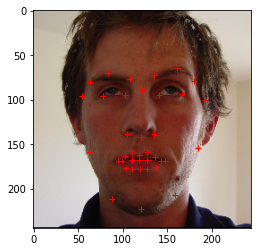

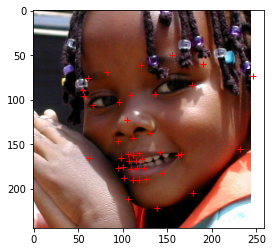

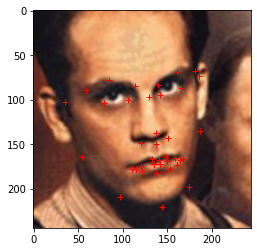

In [8]:

def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

# Calculating Prediction Error and exporting results

In [1]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [ ]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==2*42, 'wrong number of points provided. There should be 42 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


------
My assignment code
------



In [1]:
import tensorflow as tf
keras = tf.keras
layers = tf.keras.layers
# Include numpy for basic stuff
import numpy as np
# matplotlib allows us to visualise our data.
import matplotlib.pyplot as plt
# Import a library for displaying models
from IPython.display import Image

11501568/11490434 [==============================] - 0s 0us/step
(2811, 244, 244, 3) (2811, 42, 2)


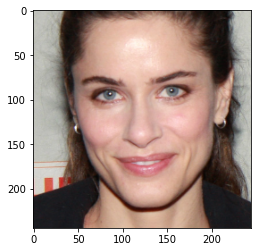

In [10]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
points = []
(x_train, y_train), (x_test, y_test) = (images, pts), (test_images, points)
# Print the shapes of the array and the unique label 
print(x_train.shape, y_train.shape)#, np.unique(y_test))

# Pick an example index
example_idx = 0
plt.imshow(x_train[example_idx,...],cmap='gray')
# Print the label
plt.show()

In [15]:
# Divide the image data to put it in the right range and convert to floating point numbers
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Convert the labels to floating point
y_train = y_train.astype("float32")
#y_test = y_test.astype("float32")

# Reserve the last -10,000- (450) samples for validation. We can use these to optimise our hyper-parameters.
x_val = x_train[-450:]
y_val = y_train[-450:]
x_train = x_train[:-450]
y_train = y_train[:-450]

# Prepare the training dataset into batches and shuffle the examples
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset into batches
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

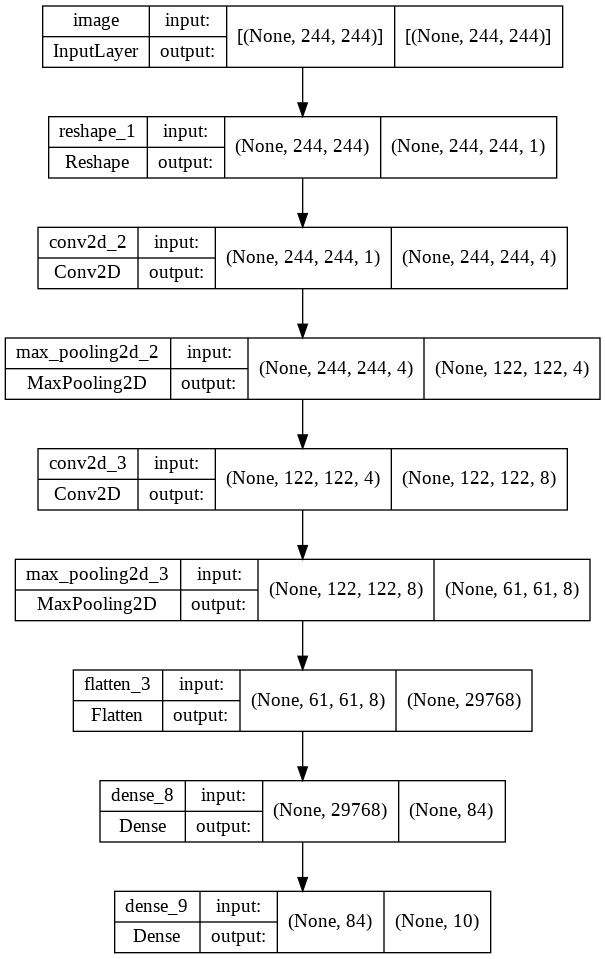

In [20]:
def build_conv_model():
  # Return a convolutional model using the functional API
  # Note that the Input size relates to the size of each instance
  inputs = keras.Input(shape=(244,244), name="image")
  net = inputs
  # We need to reshape the data before convolution such that it's grayscale image with 1 channel
  # Note we create the object, and then call it
  net = layers.Reshape((244,244,1))(net)

  # We can also define the layer object, and store it in a Python variable and call it later
  # We're more likely to want to do this for layers that contain model weights
  conv1 = layers.Conv2D(filters=4, kernel_size=3, padding='same', activation='relu')
  net = conv1(net)
  net = layers.MaxPool2D()(net)

  conv2 = layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')
  net = conv2(net)
  net = layers.MaxPool2D()(net)

  dense1 = layers.Dense(units=84, activation='relu')
  # We need to flatten the spatial dimensions before putting it through the dense layers
  net = layers.Flatten()(net)
  net = dense1(net)
  dense2 = layers.Dense(units=10, activation='softmax')
  net = dense2(net)

  return keras.Model(inputs=inputs, outputs=net)

conv_model = build_conv_model()

# Draw the network diagram
keras.utils.plot_model(conv_model, "conv_model.png", show_shapes=True)
Image(retina=True, filename='conv_model.png')


In [21]:
conv_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
conv_model.fit(train_dataset, batch_size=64, epochs=20, validation_data=val_dataset)

Epoch 1/20


ValueError: ignored